In [24]:
# Standard initialization for 21cmFAST tutorials
import py21cmfast as p21c
import numpy as np
import matplotlib.pyplot as plt
from py21cmfast import plotting
from py21cmfast.wrapper import cfuncs as cf # C function hooks
from astropy import units
import astropy.constants as const
import astropy.cosmology as cosmo
from tempfile import mkdtemp
from pathlib import Path
import cv2
import os


cache = p21c.OutputCache(mkdtemp()) # Create a temporary directory for the cache

# For this tutorial, we will also use the Dicke analytic growth factor that we wrote in class
# (this doesn't seem to be in the py21cmfast package, but it is a simple function)
#def dicke(z,Omega_m=0.3):
 #   Omega_z = Omega_m*(1.+z)**3/(Omega_m*(1.+z)**3 + (1.-Omega_m)) # Here we assume for simplicity that Omega_Lambda = 1 - Omega_m
  #  g_Omega_m = 5./2. * Omega_m*pow(1./70. + 209.*Omega_m/140. - Omega_m**2/140. + pow(Omega_m,4./7.),-1.)
   # g_Omega_z = 5./2. * Omega_z*pow(1./70. + 209.*Omega_z/140. - Omega_z**2/140. + pow(Omega_z,4./7.),-1.)
    #D = 1./(1.+z)*g_Omega_z/g_Omega_m
    #return D

### Evolving the matter field
***
In this tutorial we will learn how to evolve the initial conditions using both Eularian and Lagrangian perturbation theory.

We will use the functionality of 21cmFAST that is discribed in detail here
[https://21cmfast.readthedocs.io/en/latest/tutorials/coeval_cubes.html](https://21cmfast.readthedocs.io/en/latest/tutorials/coeval_cubes.html)

We begin by creating **initial conditions** (or load from previous tutorial).

In [4]:
### Create and visualize the initial conditions (standardize this)

# set up the global parameters
inputs = p21c.InputParameters.from_template(
    "simple", random_seed=1234
).evolve_input_structs(BOX_LEN=300.0, DIM=800, HII_DIM=200, N_THREADS=6) #adapt N_THREADS to your machine

# make initial conditions (or load them from previous run)
initial_conditions = p21c.compute_initial_conditions(inputs=inputs, cache=cache)

As we did in the previous lesson, let's use 'show slice' to visualize a 2D slice of the initial conditions.

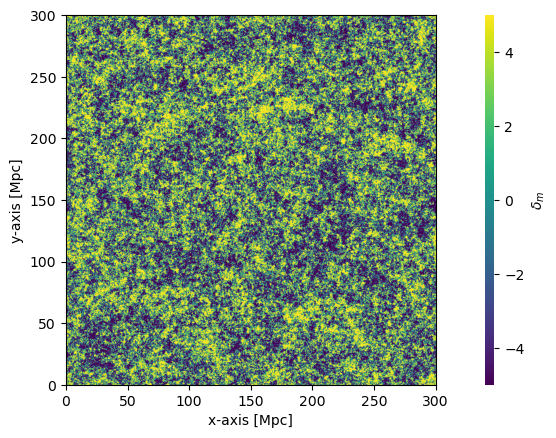

In [ ]:
### visualize the initial conditions
# plot a 2D slice
ICslice, ICaxis = plotting.coeval_sliceplot(
    initial_conditions, "hires_density", cbar_label='$\\delta_m$', cmap="viridis", vmin=-5, vmax=5
    )

Now let's try **evolving** the initial conditions using **Eularian linear perturbation theory**.

Recall that the output is the linearly-extrapolated growing mode of the overdensity field, $\delta_m \equiv \rho/\bar{\rho}-1$.

So the Eularian evolution would just scale ALL modes by the **growth factor**.  

You can use the `cf.get_growth_factor(inputs, redshift)` for the growth_factor.<br>
Let's look at the following redshifts: `redshifts = [100, 20, 10, 5, 0]', and remember to set the same color bar range using 'vmin' and 'vmax' so that the different redshift outputs can be compared more easily.


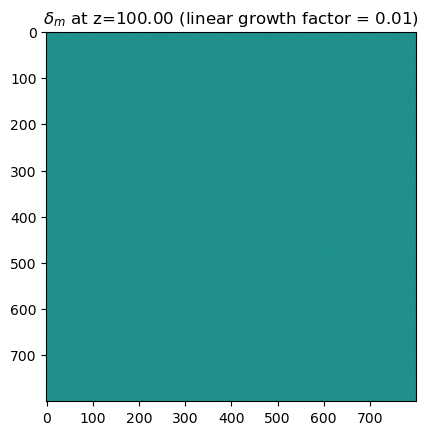

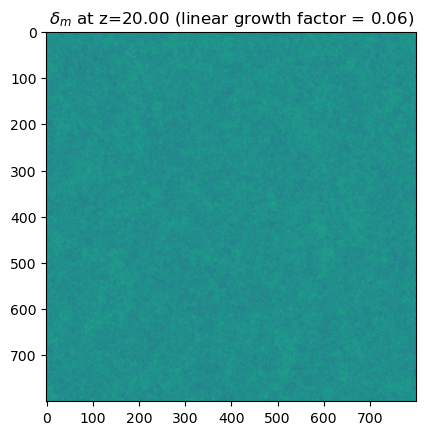

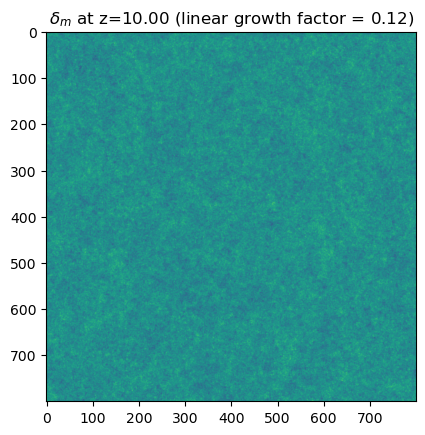

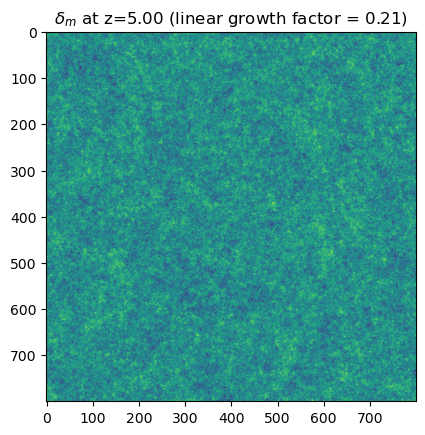

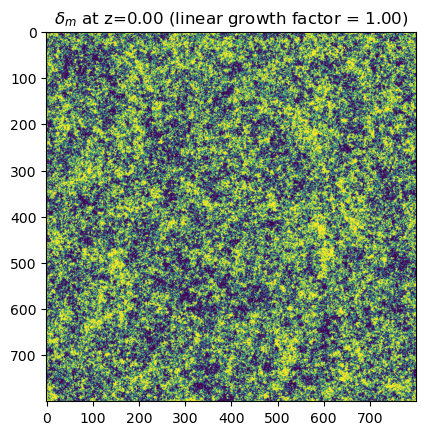

In [7]:
# let us loop over redshifts and update the plots above
redshifts = [100, 20, 10, 5, 0]
for z in redshifts:
    D = cf.get_growth_factor(inputs=inputs, redshift=z) # compute the linear growth factor
    plt.imshow(initial_conditions.hires_density.value[:,:,0] * D, vmin=-5, vmax=5) # plot 2D slice; to be replaced
    plt.title(f"$\\delta_m$ at z={z:.2f} (linear growth factor = {D:.2f})")
    plt.show()

*Can we see the growth of non-linear structure?  How would you expect the true Universe to evolve?*

Eularian perturbation theory (perturbing the overdensity, $\delta_m$) only changes the contrast independently of the scale.  
There is no mass transfer between cells, no cosmic web...

Let's get more quantitiative and use the `power spectra` and `histogram` functions to plot the spherically-averaged power spectra, and histograms computed on the cell size at these redshifts.

In [ ]:
# plot the 1D power spectrum and the PDF
#for z in redshifts:


As expected, the variance of the matter field increases with redshift and the power spectra only changes in amplitude.<br>
*How would you expect these quantities to evolve in the real Universe as structures form?*
***

Luckily, we can use the powerful **Spherical Collapse Model** to connect the **linear matter overdensity** to **halos**.

Let's start by checking what is the smallest halo mass that we can resolve with this simulation.<br>
Recall that the initial conditions are computed on a grid whose side length is:<br>
 `(inputs.simulation_options.BOX_LEN / inputs.simulation_options.DIM`.<br>
Also, note that the critical density can be accessed from the astropy object `inputs.cosmo_params.cosmo.critical_density0`

In [10]:
###  Compute the mass in a cell
rho_crit = inputs.cosmo_params.cosmo.critical_density0.to(units.Msun/units.Mpc**3)  # in Msun Mpc^-3
OMm = inputs.cosmo_params.OMm # matter density parameter
cell_len = (inputs.simulation_options.BOX_LEN / inputs.simulation_options.DIM) *units.Mpc # size of a cell in Mpc
cell_mass = rho_crit * OMm * cell_len**3
print(f"Lagrangian mass in a cell = {cell_mass:.2e}")

Lagrangian mass in a cell = 2.07e+09 solMass


Let's identify halos more massive than the cell mass at z=5

In [ ]:
# plot of the same 2D slice at z=5, but with red symbols marking cells with delta > 1.686

What about z=10?

In [7]:
# plot of the same 2D slice at z=5, but with red symbols marking cells with delta > 1.686

Compute the collapse fraction inside halos more massive than the cell mass at `redshifts` directly from `initial_conditions.hires_density.value` and compare to published works.

*Do your results make sense?*

In [11]:
# compute the fraction of cells with delta > 1.686 and multiply by 2
for z in [0,5,10]:
    D = cf.get_growth_factor(inputs=inputs, redshift=z)
    # compute the fraction of cells with delta > 1.686
    f = np.sum(initial_conditions.hires_density.value > (1.686 / D)) / initial_conditions.hires_density.value.size
    print(f"f_coll(M_halo>{cell_mass:.0e}, z={z:.2f}) = {2*f:.3f}")

f_coll(M_halo>2e+09 solMass, z=0.00) = 0.730
f_coll(M_halo>2e+09 solMass, z=5.00) = 0.104
f_coll(M_halo>2e+09 solMass, z=10.00) = 0.003


*Why did we need a factor of two?*

Ok, now let us treat the field as particles and perturb their **DISPLACEMENT** (instead of the overdensity that we perturbed using Eularian PT).  This is called **Lagrangian perturbation theory (LPT)**.

21cmFAST has a function called `PERTURB_FIELD` that we can use for this purpose.  Let's use `PERTURB_FIELD` to plot the density field at the same redshifts as above.

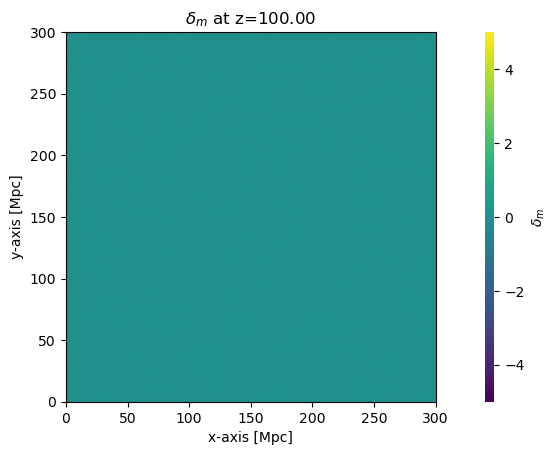

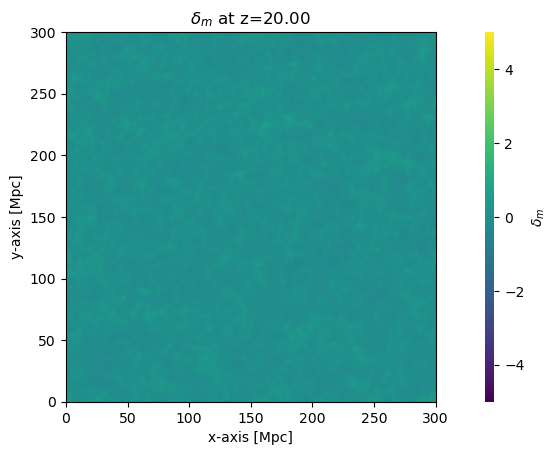

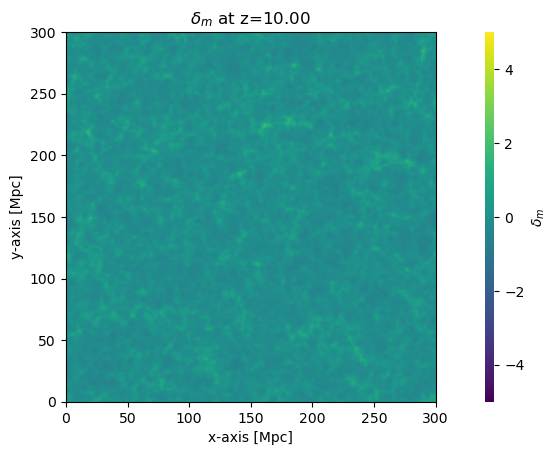

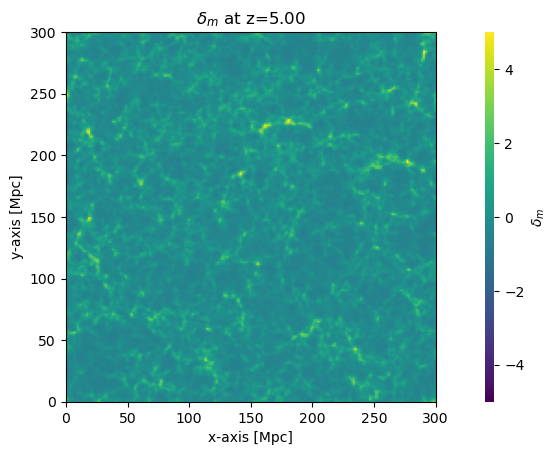

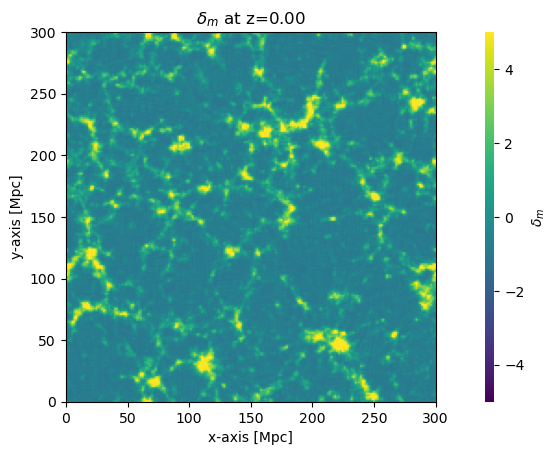

In [13]:
# let us loop over redshifts and update the plots above
for z in redshifts:
    perturbed_field = p21c.perturb_field(redshift=z, initial_conditions=initial_conditions, cache=cache)
    #plt.imshow(perturbed_field.density.value[:,:,0], vmin=-5, vmax=5) # plot 2D slice; to be replaced
    plotting.coeval_sliceplot(perturbed_field, "density", cbar_label='$\\delta_m$', cmap="viridis", vmin=-5, vmax=5);
    plt.title(f"$\\delta_m$ at z={z:.2f}")
    plt.show()
   

*How does Lagrangian PT theory compare with Eularian?  Do you see a "web"?*

*Note that in oder to define a matter overdensity, we used our high resolution `DIM` grid as "particles", moved them, and then re-bined them to a lower resolution `HII_DIM` grid. Thus these fields are lower resolution that the ones we saw earlier.*


The `PERTURB_FIELD` function actually allows us to use different perturbation theories to evolve the density field.  We can chose from Eularian, first order LPT (i.e. the Zel'dovich Approximation), and second order LPT (2LPT).  Let's plot the density fields at these redshits in a three column plot where each column corresponds to one of these methods.

In [ ]:
# make the plot from above

Now let's get a bit more quantitative and plot the corredsponding power spectra and PDFs, with one panel per redshift

*How do the methods compare?*  

*Do you see the emergence of a non-linear scale?  Comment on this scale and it's evolution...*

***
**BONUS: Let's make a movie!**


You can make a movie of your Universe evolving with time.  Let's plot the 2D slices through the matter fields evolved with 2LPT, for logarithmic redshift evolution.  We will save the plots to a local directory as images and then use `OPENCV` to combine them into a movie.

In [64]:
# make a 'Frames' directory
frames_folder = './Frames'
video_name = 'matter_evolution_2LPT.avi'
Path(frames_folder).mkdir(parents=True, exist_ok=True)
os.system("rm "+frames_folder+"/*.*"); # remove existing files
os.system("rm "+video_name); # remove existing files

In [58]:
# loop over redshifts and make plots
num_frames = 100
for z in np.logspace(1.5, -0.5, num_frames):
    perturbed_field = p21c.perturb_field(redshift=z, initial_conditions=initial_conditions, cache=cache)
    #plt.imshow(perturbed_field.density.value[:,:,0], vmin=-5, vmax=5) # plot 2D slice; to be replaced
    plotting.coeval_sliceplot(perturbed_field, "density", cbar_label='$\\delta_m$', cmap="viridis", vmin=-5, vmax=5);
    plt.title(f"$\\delta_m$ at z={z:.2f}");
    plt.savefig(f"./Frames/matter_overdensity_z{z:06.2f}.png");
    plt.close();


In [ ]:
# make a movie from the frames
images = [img for img in sorted(os.listdir(frames_folder))[::-1] if img.endswith(".png")]
frame = cv2.imread(os.path.join(frames_folder, images[0]))
height, width, layers = frame.shape

fps=5
video = cv2.VideoWriter(video_name, 0, fps, (width,height))
for image in images:
    video.write(cv2.imread(os.path.join(frames_folder, image)))

cv2.destroyAllWindows()
video.release()